In [1]:
import numpy as np
import pandas as pd
import scanpy as sc

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

# For editable text. Except latex text is still shapes sadly
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
sns.set_style("whitegrid")
font = {'size' : 6}
lines = {'linewidth' : 0.5}
fig = {'figsize' : (2.5, 1.5)}
mpl.rc('font', **font)
mpl.rc('lines', **lines)
mpl.rc('figure', **fig)

# Set style
sns.set(style="whitegrid", palette="pastel", color_codes=True)
import mygene
import os

from sklearn.metrics.pairwise import cosine_similarity


import mygene
from numpy import linalg as LA

In [2]:
def save_figure_pdf(fig, path_to_save):
	'''
	Utility fxn to save a figure without having to retype all the required options.
	Input:
		fig - a matplotlib.pyplot.figure instance with the figure you'd like to save
		path_to_save - the path you'd like to save the figure to
	Returns: Nothing but there should now be a pdf version in 300 dpi with a transparent bkg at path_to_save
	'''
	fig.savefig(path_to_save, dpi = 300, bbox_inches = 'tight', transparent = True)

In [3]:
figSavePath = "/Users/kayaneh/Documents/deconvolution/figures/full_figure/maintext_revision1/"

In [4]:
# import HPA
hpa = pd.read_csv("../signatures_git/tissue_category_rna_Any_Tissue-2.tsv",
                  index_col = 0,sep = "\t")

In [5]:
# cpm counts of biological replicates

adBase = "/Users/kayaneh/Documents/deconvolution/alzheimers/remapped_unstranded/"

# this file has the stray AD sample, 3224 that originally wasnt on SRA
aprilTMM = pd.read_csv(adBase + "ad_cpmOnly_postQC_unstranded_FINAL.csv",
                    sep = ",", index_col = [0, 1])

aprilTMM.columns = [int(i) for i in aprilTMM.columns]

adMeta = pd.read_csv(adBase + "allAD_metadata_FINAL.csv",
                    sep = ",", index_col = 0)


print(adMeta.shape)
adMeta = adMeta[adMeta["Isolate"].isin(aprilTMM.columns)]

(339, 40)


In [6]:
kyMeta = adMeta[adMeta["Center"] == "BioIVT"]
kyMeta = kyMeta[kyMeta["Disease"] == "NCI"]
kyIsolate = np.unique(kyMeta["Isolate"]).tolist()
print(len(kyIsolate))

18


In [7]:
thuyCPM = aprilTMM[kyIsolate]

In [8]:
thuyCPM.reset_index(inplace = True)

In [9]:
thuyCPM.set_index("gene_name", inplace = True)
thuyCPM.drop("gene_num", inplace = True, axis = "columns")

/Users/kayaneh/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:4170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [10]:
thuyCPM.head()

,17923,17924,17925,17926,17927,17929,17931,17932,17933,17934,17938,17940,17943,17944,17946,17947,17949,17953
gene_name,,,,,,,,,,,,,,,,,,
TSPAN6,2.398423,3.417658,2.280461,1.891905,0.668724,0.000000,0.000000,0.947058,7.874481,2.695946,0.000000,3.281909,1.655451,4.237117,0.000000,0.269570,0.000000,0.000000
TNMD,0.266491,0.525794,0.350840,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.237117,0.000000,0.000000,0.000000,0.000000
DPM1,42.372141,25.763886,22.980033,27.874065,14.043202,14.512962,11.022026,5.682348,2.952930,3.594594,0.666186,6.563817,1.655451,15.536096,3.844542,0.539140,0.974539,11.937777
SCYL3,22.385282,10.252975,10.876046,17.405525,15.046287,5.805185,7.110985,6.155877,5.905861,0.898649,1.665465,0.820477,6.621804,1.412372,2.306725,1.213064,1.949078,10.852525
C1orf112,5.862812,3.943452,7.016804,2.900921,1.003086,2.031815,1.777746,6.629406,0.984310,1.797297,1.665465,4.102386,1.655451,1.412372,0.000000,0.000000,0.000000,4.341010


In [11]:
sigMat = "deconvolve_cfrna_TSP/tsp_v1_basisMatrix.txt"
sigMat = pd.read_csv(sigMat, sep = "\t", index_col = 0)

In [12]:
# address the fact that a lot of genes in cell free 
# might be HPA synonyms rather than in the list

# make a dictionary where the keys are the OG genes
# and the values are the synonyms
synDict = hpa["Gene synonym"].fillna("")
synDict = synDict.to_dict()

for k in synDict:
    if type(k) == str:
        synDict[k] = synDict[k].split(", ")
    else: continue

In [13]:
# go through each healthy srr
res = pd.DataFrame()


cpm_thresh = 1 # units are CPM
hpaNX_thresh = 10 # units are NX 

allTissGenes = {}

# go through each biological replicate
for srr in thuyCPM:

    # subset the mixture
    cfMix = thuyCPM[srr].to_frame()
    srr = str(srr)
    
    print(len(cfMix.index.tolist()))
    
    # genes in mixture greater than or equal to CPM threshold
    cfMix = cfMix[cfMix.values >= cpm_thresh] 
    
    print(cfMix.shape)
    
    # get genes + synonyms to make sure nothing is missing
    cfGenes = cfMix.index.tolist()

    # genes in mixture not in signature matrix
    inMixture = np.setdiff1d(cfGenes, sigMat.index.tolist())
    print("in Mixture = ", len(inMixture))
    
    #### ACCOUNT FOR GENES THAT ARE SYNONYMS ####
    # synDict is a dictionary of the synonyms of the HPA genes
    # loop throught the keys
    
    inSynDict = []

    # get set difference of what's in the mixture and what's not reflected in HPA
    missList = np.setdiff1d(cfGenes, list(synDict.keys()))

    # go through the genes not the main HPA entries and get the HPA synonyms
    for gene in missList:
        for k in synDict:
            if gene in synDict[k]: # if the gene is a synonym
                inSynDict += [k] # add the parent key back (e.g. it's in the index of HPA)
                    
    missingInHPA = hpa.loc[np.unique(inSynDict)].index.tolist()

    
    # look at the genes then do tiss based off that
    allGenesInCFInHPA = list(np.intersect1d(hpa.index, inMixture)) + missingInHPA
    allGenesInCFInHPA = list(np.unique(allGenesInCFInHPA))
    
    print("in Mixture in HPA ", len(allGenesInCFInHPA))
    cfInHPA = hpa.loc[allGenesInCFInHPA]
    cfInHPA = cfInHPA.drop_duplicates(keep = "first", subset = "Ensembl") # have distinct gene names
    topTiss = cfInHPA[['RNA tissue specific NX']].values # list of top tiss and the NX values
    
    geneDict = {}
    geneNames = {}
    
    for j in topTiss:
        splitGene = j[0].split(";")
        
  
        for t in splitGene:
            t = t.split(": ")
            tiss, nxCount = t[0], float(t[1])
            if nxCount > hpaNX_thresh:
                if tiss not in geneDict:
                    geneDict[tiss] = 1
                    geneNames[tiss] = [gene]
                else:
                    geneDict[tiss] += 1
                    geneNames[tiss] += [gene]
   
    hpaGenes = pd.DataFrame(geneDict, index = [1]).T
    hpaGenes.columns = [srr + " - # Genes"]
    hpaGenes.sort_index(inplace = True)
    
    res = pd.concat([res, hpaGenes], axis  = 1)

60721
(13525, 1)
in Mixture =  3105
in Mixture in HPA  1039
60721
(13330, 1)
in Mixture =  3082
in Mixture in HPA  1000
60721
(13051, 1)
in Mixture =  2943
in Mixture in HPA  963
60721
(13100, 1)
in Mixture =  2968
in Mixture in HPA  949
60721
(12947, 1)
in Mixture =  3046
in Mixture in HPA  1003
60721
(12959, 1)
in Mixture =  3057
in Mixture in HPA  999
60721
(13068, 1)
in Mixture =  3149
in Mixture in HPA  1030
60721
(12292, 1)
in Mixture =  2945
in Mixture in HPA  1005
60721
(10302, 1)
in Mixture =  2618
in Mixture in HPA  813
60721
(9937, 1)
in Mixture =  2570
in Mixture in HPA  776
60721
(7194, 1)
in Mixture =  1861
in Mixture in HPA  523
60721
(11530, 1)
in Mixture =  2860
in Mixture in HPA  912
60721
(13694, 1)
in Mixture =  4325
in Mixture in HPA  1511
60721
(14324, 1)
in Mixture =  4254
in Mixture in HPA  1496
60721
(12914, 1)
in Mixture =  3340
in Mixture in HPA  1218
60721
(6913, 1)
in Mixture =  1749
in Mixture in HPA  458
60721
(11543, 1)
in Mixture =  3182
in Mixture in H

In [14]:
# get the tiss
res["tiss"] = res.index

# get the sorted values so the bars are in a specific order
sortedTiss = res.mean(axis = 1).sort_values(ascending = False)

# re-sort res based on the ascending average values
res = res.loc[sortedTiss.index]

In [15]:
meltedCts = pd.melt(res, value_vars = res.columns[:-1], id_vars = ["tiss"])

In [16]:
meltedCts = meltedCts.sort_values(by = "value", ascending = False)

In [17]:
highestTiss = sortedTiss[sortedTiss >= 75]

In [18]:
subMeltedCts = meltedCts[meltedCts["tiss"].isin(highestTiss.index.tolist())]

(0.0, 400.0)

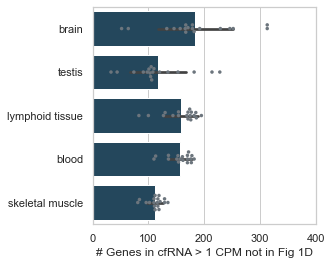

In [19]:
plt.figure(figsize = (4, 4))
sns.barplot(x = "value", y = "tiss", 
            data = subMeltedCts, ci = "sd",
           color = "#1b4965") 

sns.swarmplot(x = "value", y = "tiss", size = 3.5,
            data = subMeltedCts,
           color = "#6c757d") 

plt.ylabel("")
plt.xlabel("# Genes in cfRNA > 1 CPM not in Fig 1D")
plt.xticks(np.arange(0, 401, 100))
plt.xlim(0, 400)

save_figure_pdf(plt, "missingFromSigMat_HPAPLASMA_sigmat18_fig1e_11302021.pdf")

In [20]:
len(np.unique(subMeltedCts['variable']))

18

In [21]:
clear all